In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import uniform
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from sklearn.preprocessing import LabelEncoder

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
test  = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')

# 삭제 전 ID 저장
train_idx = train['id']
test_idx = test['id']

train = train.drop(columns=['id'])
test = test.drop(columns=['id'])

# 데이터에 파생변수1 추가
def cal_loan_mean_ratio(df):
    
    mean_lst = df.groupby('loan_grade')['loan_amnt'].mean()
    df['loan_amnt_mean_ratio'] = df.apply(lambda x: x['loan_amnt'] / mean_lst[x['loan_grade']], axis = 1)
    
    return df

train = cal_loan_mean_ratio(train)
test = cal_loan_mean_ratio(test)

'''
# 데이터에 파생변수 2 추가
# 가중치 검사 및 검증 결과 유의미하지 않음
def int_rate_by_Credlength(df):
    df['int_rate_by_Credlength'] = df['loan_int_rate'] / df['cb_person_cred_hist_length']
    return df

train = int_rate_by_Credlength(train)
test = int_rate_by_Credlength(test)
'''

# 데이터에 파생변수 3 추가
# 유효하지 않은 열을 유효하게 -> 나이/재직기간을 범주화 하자.

def categorize_age(age):
    if age < 20:
        return 0
    elif 20 <= age < 30:
        return 1
    elif 30 <= age < 40:
        return 2
    elif 40 <= age < 50:
        return 3
    else:
        return 4

train['age_to_categorial'] = train['person_age'].apply(categorize_age)
test['age_to_categorial'] = test['person_age'].apply(categorize_age)


# 데이터에 파생변수 4 추가
# 재직기간의 범주화
'''
def categorize_emp(emp):
    if emp < 3:
        return 0
    elif 3 <= emp < 6:
        return 1
    elif 6 <= emp < 10:
        return 2
    elif 10 <= emp < 20:
        return 3
    else:
        return 4

train['emp_to_categorial'] = train['person_emp_length'].apply(categorize_emp)
test['emp_to_categorial'] = test['person_emp_length'].apply(categorize_emp)
'''

"\ndef categorize_emp(emp):\n    if emp < 3:\n        return 0\n    elif 3 <= emp < 6:\n        return 1\n    elif 6 <= emp < 10:\n        return 2\n    elif 10 <= emp < 20:\n        return 3\n    else:\n        return 4\n\ntrain['emp_to_categorial'] = train['person_emp_length'].apply(categorize_emp)\ntest['emp_to_categorial'] = test['person_emp_length'].apply(categorize_emp)\n"

In [4]:
def Na_mean_change(df, features):
    
    for col in features:
        df[col].fillna(df[col].mean(), inplace = True)
    
    pd.DataFrame(df)
    return df

In [5]:
def preprocess_data(df_train, df_test):
    label_enc = LabelEncoder()
    
    label_cols = ['person_home_ownership', 'loan_grade', 'cb_person_default_on_file']
    
    for col in label_cols:
        df_train[col] = label_enc.fit_transform(df_train[col])
        df_test[col] = label_enc.transform(df_test[col])
        
    df_train = pd.get_dummies(df_train, columns = ['loan_intent'], drop_first = True)
    df_test = pd.get_dummies(df_test, columns = ['loan_intent'], drop_first = True)
    
    target_col = 'loan_status'
    train_columns = df_train.drop(columns =[target_col]).columns
    
    df_test = df_test.reindex(columns = train_columns, fill_value = 0)
    
    return df_train, df_test

In [6]:
train2 = train
test2 = test

In [7]:
Na_mean_change(train2, ['person_emp_length', 'loan_int_rate'])
df_test = Na_mean_change(test2, ['person_emp_length', 'loan_int_rate'])

/tmp/ipykernel_17/1428734830.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace = True)


In [8]:
train2, test2 = preprocess_data(train2, test2)

In [9]:
X = train2.drop(columns = 'loan_status', axis = 1).iloc[:,:-5]
y = train2['loan_status']

In [10]:
# 변수 가중치 계산

model = LogisticRegression(random_state = 42)
model.fit(X,y)

# 가중치 계산식에 맞게 계산하기
weights = model.coef_[0] * (X.max(axis=0) - X.min(axis=0)) / X.std(axis=0)

# 가중치 출력
sorted_idx = weights.argsort()[::-1]
for i in sorted_idx:
    print(f"{X.columns[i]}: {weights[i]}")

cb_person_cred_hist_length: 1.3057299177407082
loan_int_rate: 1.2141916999205415
loan_grade: 1.1372685649108478
person_home_ownership: 0.12762597418627591
cb_person_default_on_file: 0.09026649599935584
age_to_categorial: 0.08383581023082662
loan_amnt: 0.0010466343273732208
person_income: -0.002793665626863401
loan_percent_income: -0.013853335616839966
loan_amnt_mean_ratio: -0.1167690565887569
person_emp_length: -2.4799810252962002
person_age: -2.481890820384232


/tmp/ipykernel_17/483765551.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{X.columns[i]}: {weights[i]}")


In [11]:
# 가중치가 음수인 것 중 절댓값이 큰 칼럼들 제거
#['person_age', 'person_emp_length']

## 이하는 머신러닝 파트라 일단 무시

ROC-AUC 점수: 0.9057


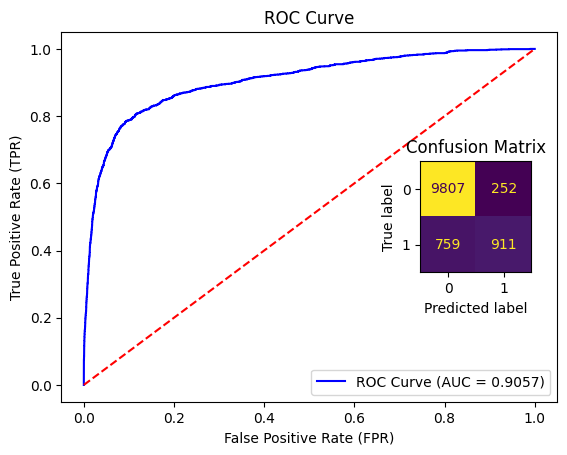

In [12]:

# 데이터 준비 - 여기까지만 손댈것!
y = train['loan_status']  # 타겟 변수
X = train.drop(['loan_status','person_age', 'person_emp_length'], axis=1)  # 특징 변수

# 학습 및 검증 데이터셋 나누기
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 범주형 및 수치형 변수 정의
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# 전처리 및 모델 파이프라인 설정
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # 수치형 컬럼에 대해 StandardScaler 적용
        # ('cat', OrdinalEncoder(), categorical_cols)  # 범주형 컬럼에 대해 OrdinalEncoder 적용 0.88
         ('cat', OneHotEncoder(drop='first'), categorical_cols)  # 범주형 컬럼에 대해 OneHotEncoder 적용
        
    ]
)

logistic_pipeline = make_pipeline(
    preprocessor,
    LogisticRegression(solver='liblinear')  # 로지스틱 회귀 모델
)

# 하이퍼파라미터 튜닝 (ROC-AUC 스코어 기준)
param_distributions = {
    'logisticregression__C': uniform(0.01, 10),  # 정규화 강도
    'logisticregression__penalty': ['l1', 'l2']  # 정규화 방식
}

random_search = RandomizedSearchCV(
    logistic_pipeline, 
    param_distributions, 
    n_iter=100, 
    cv=2, 
    random_state=42, 
    n_jobs=-1, 
    scoring='roc_auc'  # ROC-AUC를 기준으로 스코어링
)

# 모델 학습
random_search.fit(X_train, y_train)

# 검증 세트에 대한 예측 확률 계산
y_val_probs = random_search.predict_proba(X_val)[:, 1]  # 클래스 1(양성 클래스)에 대한 확률 추출

# ROC-AUC 점수 계산 및 출력
roc_auc = roc_auc_score(y_val, y_val_probs)
print(f'ROC-AUC 점수: {roc_auc:.4f}')

# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)

# ROC 곡선 그리기
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], color='red', linestyle='--')  # 랜덤 추측선
ax.set_xlabel('False Positive Rate (FPR)')  # 위양성 비율
ax.set_ylabel('True Positive Rate (TPR)')  # 진양성 비율
ax.set_title('ROC Curve')
ax.legend(loc='lower right')

# 그리드 제거
ax.grid(False)

# 검증 데이터에 대한 예측 값 생성
y_val_preds = random_search.best_estimator_.predict(X_val)

# 혼동 행렬 계산
cm = confusion_matrix(y_val, y_val_preds)

# ROC 곡선 안에 혼동 행렬 삽입
ax_inset = inset_axes(ax, width="30%", height="30%", loc="center right")  # 위치 조정 가능
ConfusionMatrixDisplay(cm).plot(ax=ax_inset, colorbar=False)
ax_inset.grid(False)  # 혼동 행렬에 그리드 제거
ax_inset.set_title('Confusion Matrix')  # 작은 창에 제목 추가

# 그래프 보여주기
plt.show()

# 테스트 데이터 예측 및 제출 파일 저장
test = test.loc[:, categorical_cols + numerical_cols]
now = datetime.now()

# 테스트 데이터에 대한 예측 수행
submission['loan_status'] = np.round(random_search.best_estimator_.predict_proba(test)[:, 1], 2)
submission.to_csv(f'result_{now.strftime("%Y-%m-%d_%H-%M-%S")}.csv', index=False)

## 1. 나이, 재직기간만 삭제 시
    - ROC-AUC 점수: 0.9056 (+0.0003)
## 2. 가중치 음수인 변수 모두 제거 시
    - ROC-AUC 점수: 0.8533 (-0.0517)
## 3. 가중치 음수인 변수 하위 3개 제거 시
    - ROC-AUC 점수: 0.9050 (-0.0003)
## 4. 파생변수 대출금리/신용기간 추가 시
    - ROC-AUC 점수: 0.9053 (+-0)
## 5. 나이 범주화 변수 추가 시
    - ROC-AUC 점수: 0.9057 (+0.0001)
## 6. 나이 범주화 추가 및 재직기간 범주화 추가, 파생변수 1 제거
    - ROC-AUC 점수: 0.9047 (-0.0010)


             


### 결론: 
나이, 재직기간은 실제로 통계학적으로 유의하지 않은 독립변수이다.   
새로 만든 파생변수는 꽤 모델 설명에 도움이 되는 듯 하다.   
**결론적으로, 파생변수를 더 만들어야한다!**   

### 논리:
나이와 재직기간은 유의하지 못하다.   
차라리 범주화를 시켜서 세대별로, 사회초년생~베테랑 등으로 나눌 수 있다면 더 의미있는 결과가 나올 수 있을 것 같다.
